In [1]:
'''
In this example, we will load a RefineDet model and use it to detect objects.
'''

import argparse
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import cv2
# Make sure that caffe is on the python path:
caffe_root = './'
os.chdir(caffe_root)
sys.path.insert(0, os.path.join(caffe_root, 'python'))
import caffe

from google.protobuf import text_format
from caffe.proto import caffe_pb2



def ShowResults2(img, image_file, results, threshold=0.6, save_fig=False):
    plt.figure()
    plt.imshow(img)
    ax = plt.gca()
    for i in range(0, results.shape[0]):
        score = results[i, -2]
        if threshold and score < threshold:
            continue
        label = int(results[i, -1])
#         if label != 1:
#             continue
        name = str(label)
        xmin = int(round(results[i, 0]))
        ymin = int(round(results[i, 1]))
        xmax = int(round(results[i, 2]))
        ymax = int(round(results[i, 3]))
        coords = (xmin, ymin), xmax - xmin, ymax - ymin
        ax.add_patch(plt.Rectangle(*coords, fill=False, edgecolor='white', linewidth=3))
        display_text = '%s: %.2f' % (name, score)
        ax.text(xmin, ymin, display_text, color='white')
        plt.imshow(img)
    plt.show()
    
def ShowResults(img, image_file, results, threshold=0.6, save_fig=False):
    plt.figure()
    img = cv2.imread(image_file)
    for i in range(0, results.shape[0]):
        score = results[i, -2]
        if threshold and score < threshold:
            continue
        label = int(results[i, -1])
        if label != 1:
            continue
        name = str(label)
        xmin = int(round(results[i, 0]))
        ymin = int(round(results[i, 1]))
        xmax = int(round(results[i, 2]))
        ymax = int(round(results[i, 3]))
        coords = (xmin, ymin), xmax - xmin, ymax - ymin
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (255, 255, 255), 3)
#         ax.add_patch(plt.Rectangle(*coords, fill=False, edgecolor='white', linewidth=3))
        display_text = '%s: %.2f' % (name, score)
        cv2.putText(img, display_text, (xmin, ymin), cv2.FONT_HERSHEY_SIMPLEX, 1, color=(255,255,255), thickness=3)
#         ax.text(xmin, ymin, display_text, color='white')
        plt.imshow(img)
    if save_fig:
        cv2.imwrite(image_file[:-4] + '_dets.jpg', img)
        print('Saved: ' + image_file[:-4] + '_dets.jpg')
    plt.show()

0.00449680726684%


/home/wangjilong/anaconda2/envs/pedestrian/lib/python2.7/site-packages/skimage/io/_io.py:49: UserWarning: `as_grey` has been deprecated in favor of `as_gray`
  warn('`as_grey` has been deprecated in favor of `as_gray`')
/home/wangjilong/anaconda2/envs/pedestrian/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/wangjilong/anaconda2/envs/pedestrian/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


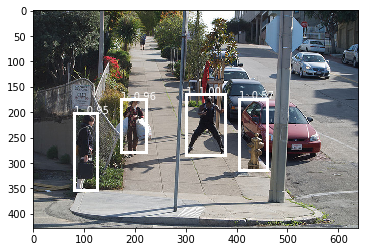

0.00899361453368%


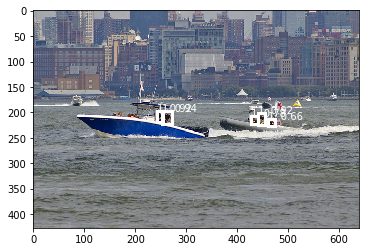

0.0134904218005%


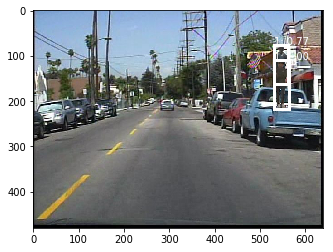

0.0179872290674%


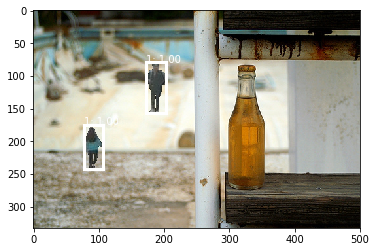

0.0224840363342%


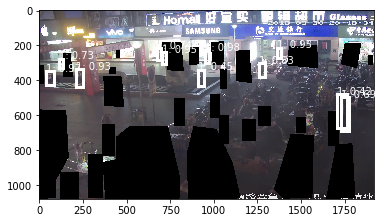

0.026980843601%


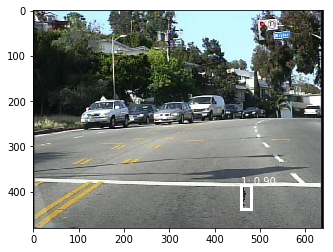

0.0314776508679%


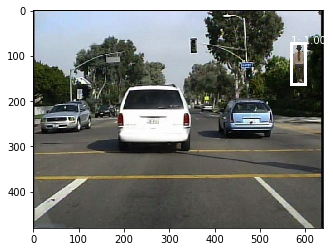

0.0359744581347%


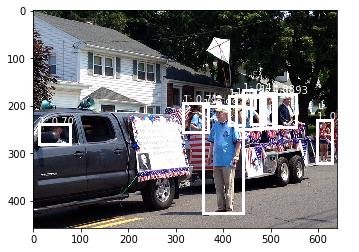

0.0404712654016%


In [ ]:
if __name__ == '__main__':
    # gpu preparation
    caffe.set_device(3)
    caffe.set_mode_gpu()

    # load model
    model_def = 'models/ResNet/coco/refinedet_resnet18_addneg_1024x1024/deploy.prototxt'
    model_weights = 'models/ResNet/coco/refinedet_resnet18_addneg_1024x1024/coco_refinedet_resnet18_addneg_1024x1024_iter_178000.caffemodel'
    net = caffe.Net(model_def, model_weights, caffe.TEST)

    # image preprocessing
    img_resize = 1024
    net.blobs['data'].reshape(1, 3, img_resize, img_resize)
    transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
    transformer.set_transpose('data', (2, 0, 1))
    transformer.set_mean('data', np.array([104, 117, 123]))  # mean pixel
    transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
    transformer.set_channel_swap('data', (2, 1, 0))  # the reference model has channels in BGR order instead of RGB

    
    im_names = os.listdir('/home/wangjilong/data/hardexamples/ImageSet')
    #print(im_names)
    #im_names = ['3_00008637_0.jpg', '3_00008659_1.jpg']
    count = len([x for x in im_names if 'dets' not in x])
    process = 0
    
    img_dir = '/home/wangjilong/data/hardexamples/ImageSet/'
    name = list(open('hardexample.txt','r').readlines())
    name = [x[:-1] for x in name]
    im_names = [x[:-10]+'.jpg' for x in name]
    
    for im_name in im_names[0:100]:
        if 'dets' in im_name:
            continue
        process = process + 1
        print(str(float(process)/count * 100) + '%')
        image_file = '/home/wangjilong/data/hardexamples/ImageSet/' + im_name
        image = caffe.io.load_image(image_file)
        transformed_image = transformer.preprocess('data', image)
        net.blobs['data'].data[...] = transformed_image

        detections = net.forward()['detection_out']
        det_label = detections[0, 0, :, 1]
        det_conf = detections[0, 0, :, 2]
        det_xmin = detections[0, 0, :, 3] * image.shape[1]
        det_ymin = detections[0, 0, :, 4] * image.shape[0]
        det_xmax = detections[0, 0, :, 5] * image.shape[1]
        det_ymax = detections[0, 0, :, 6] * image.shape[0]
        result = np.column_stack([det_xmin, det_ymin, det_xmax, det_ymax, det_conf, det_label])

        # show result
        ShowResults2(image, image_file, result, 0.4, save_fig=True)

/home/wangjilong/data/hardexamples/ImageSet/8_71574.jpg


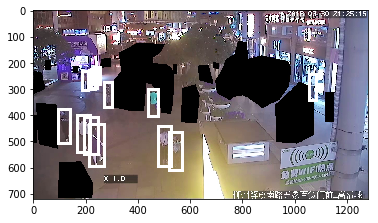

13
12
(0.0, 2.0, 1.0)
/home/wangjilong/data/hardexamples/ImageSet/1_00093767.jpg


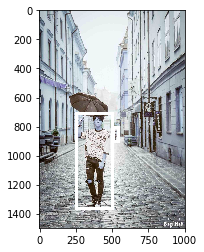

2
1
(0.0, 1.0, 0.0)
/home/wangjilong/data/hardexamples/ImageSet/9_51300.jpg


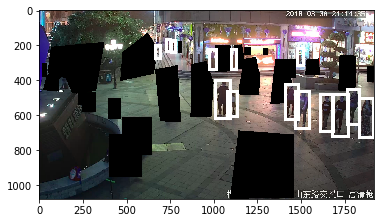

14
15
(0.0, 1.0, 2.0)
/home/wangjilong/data/hardexamples/ImageSet/ch02_20180617154538_30044.jpg


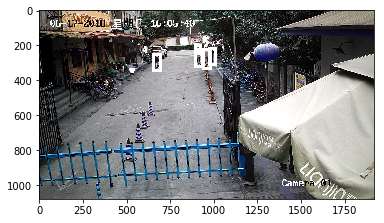

5
9
(0.0, 0.0, 4.0)
/home/wangjilong/data/hardexamples/ImageSet/ch09_20171231083000_51756.jpg


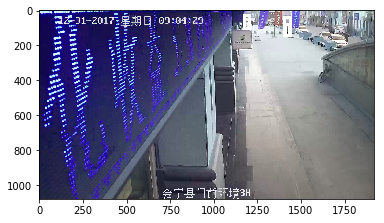

3
4
(0.0, 2.0, 3.0)
/home/wangjilong/data/hardexamples/ImageSet/4_66990.jpg


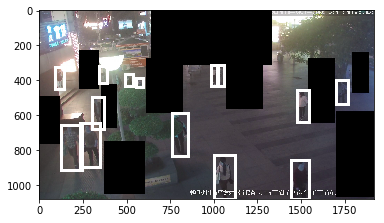

14
16
(0.0, 2.0, 4.0)
/home/wangjilong/data/hardexamples/ImageSet/9_3900.jpg


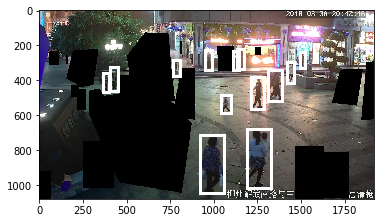

13
11
(0.0, 3.0, 1.0)
/home/wangjilong/data/hardexamples/ImageSet/liuzhoubayilubbg_127.jpg


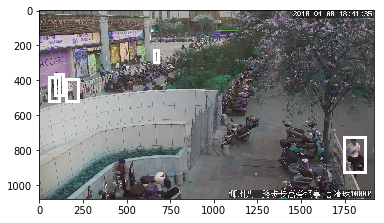

5
17
(0.0, 0.0, 12.0)
/home/wangjilong/data/hardexamples/ImageSet/cd_0652.jpg


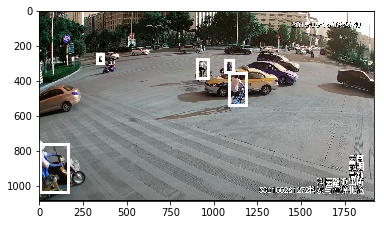

5
6
(0.0, 0.0, 1.0)
/home/wangjilong/data/hardexamples/ImageSet/gsun_b7c3850ca5962b1979a700b1f473f401.jpg


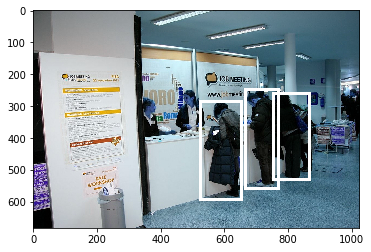

3
2
(0.0, 1.0, 0.0)
/home/wangjilong/data/hardexamples/ImageSet/4_24882.jpg


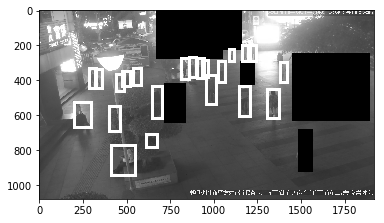

22
20
(0.0, 7.0, 5.0)
/home/wangjilong/data/hardexamples/ImageSet/2_00090153.jpg


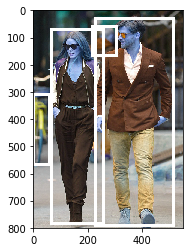

4
2
(0.0, 2.0, 0.0)
/home/wangjilong/data/hardexamples/ImageSet/cd_0282.jpg


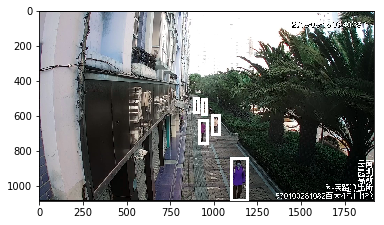

5
10
(0.0, 0.0, 5.0)
/home/wangjilong/data/hardexamples/ImageSet/6_23030.jpg


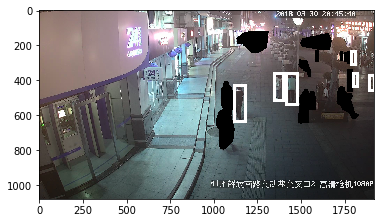

6
4
(0.0, 2.0, 0.0)
/home/wangjilong/data/hardexamples/ImageSet/cd_0086.jpg


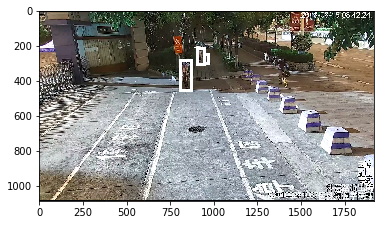

3
3
(0.0, 1.0, 1.0)
/home/wangjilong/data/hardexamples/ImageSet/6_25585.jpg


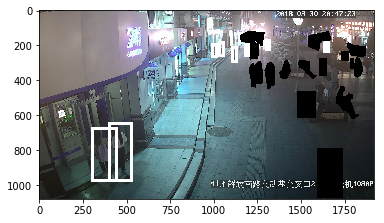

9
9
(0.0, 2.0, 2.0)
/home/wangjilong/data/hardexamples/ImageSet/liuzhoububugao_131.jpg


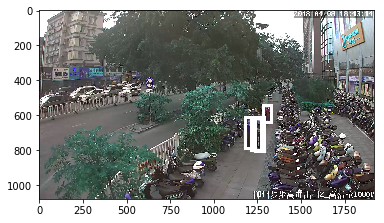

4
3
(0.0, 1.0, 0.0)
/home/wangjilong/data/hardexamples/ImageSet/gsun_0d1bd291a29a3c524c9f5c7ea8d7eb93.jpg


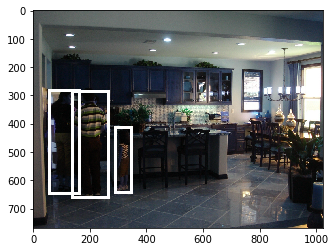

3
4
(0.0, 0.0, 1.0)
/home/wangjilong/data/hardexamples/ImageSet/ch02_20180618133324_51891.jpg


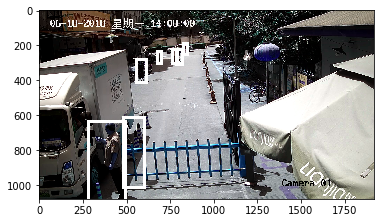

7
8
(0.0, 1.0, 2.0)
/home/wangjilong/data/hardexamples/ImageSet/cd_0803.jpg


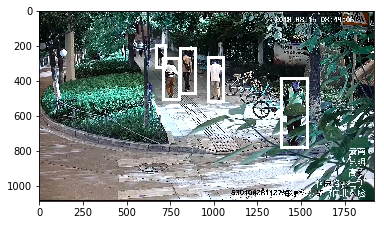

5
7
(0.0, 0.0, 2.0)
/home/wangjilong/data/hardexamples/ImageSet/6_13930.jpg


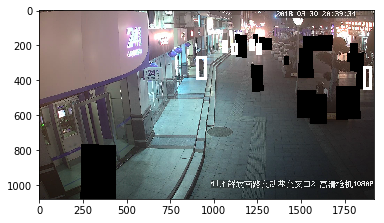

6
8
(0.0, 1.0, 3.0)
/home/wangjilong/data/hardexamples/ImageSet/4_78996.jpg


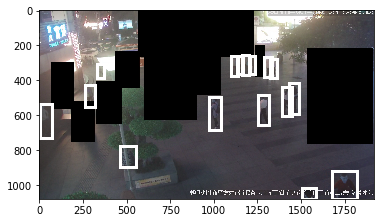

16
16
(0.0, 3.0, 3.0)
/home/wangjilong/data/hardexamples/ImageSet/C0622_MP41605.jpg


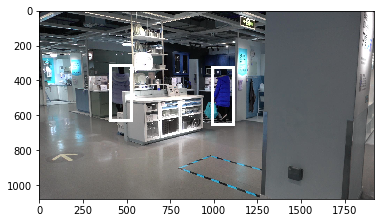

2
1
(0.0, 1.0, 0.0)
/home/wangjilong/data/hardexamples/ImageSet/9_62925.jpg


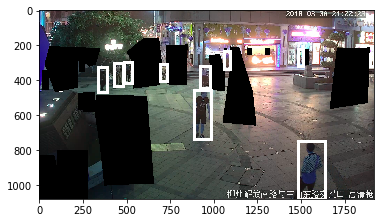

10
9
(0.0, 1.0, 0.0)
/home/wangjilong/data/hardexamples/ImageSet/ch02_20180617073119_40755.jpg


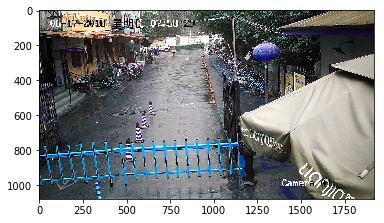

0
3
(0.0, 0.0, 3.0)
/home/wangjilong/data/hardexamples/ImageSet/hxj_170303_1403.jpg


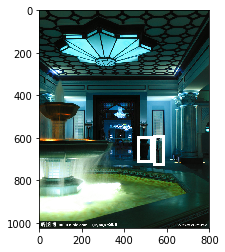

2
1
(0.0, 1.0, 0.0)
/home/wangjilong/data/hardexamples/ImageSet/062_fb00_097.jpg


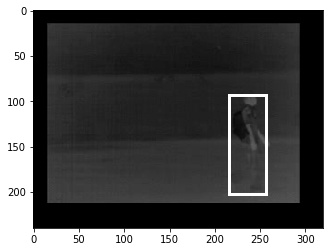

1
1
(0.0, 1.0, 1.0)
/home/wangjilong/data/hardexamples/ImageSet/133_fb00_126.jpg


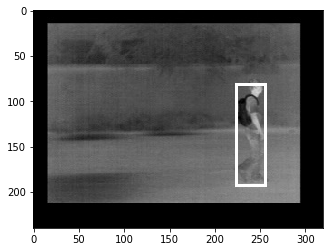

1
1
(0.0, 1.0, 1.0)
/home/wangjilong/data/hardexamples/ImageSet/4_49503.jpg


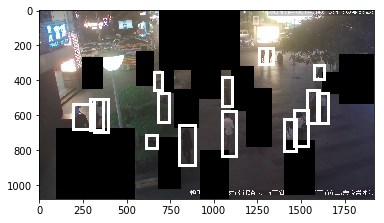

16
18
(0.0, 0.0, 2.0)
/home/wangjilong/data/hardexamples/ImageSet/ch02_20180617080645_51550.jpg


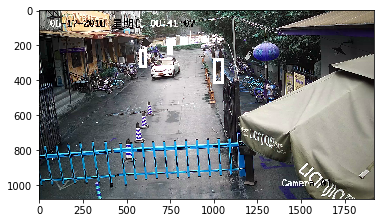

3
10
(0.0, 0.0, 7.0)
/home/wangjilong/data/hardexamples/ImageSet/125_fb01_115.jpg


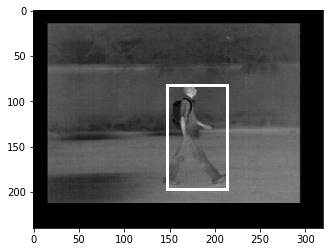

1
1
(0.0, 1.0, 1.0)
/home/wangjilong/data/hardexamples/ImageSet/9_16350.jpg


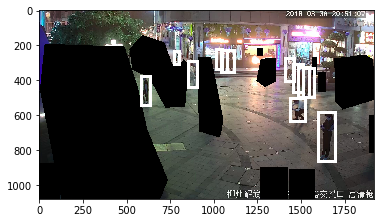

12
11
(0.0, 2.0, 1.0)
/home/wangjilong/data/hardexamples/ImageSet/liuzhoububugao_114.jpg


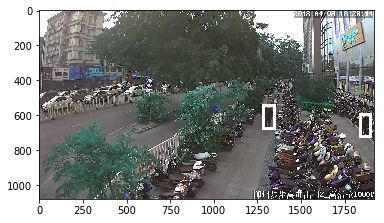

2
5
(0.0, 0.0, 3.0)
/home/wangjilong/data/hardexamples/ImageSet/9_42675.jpg


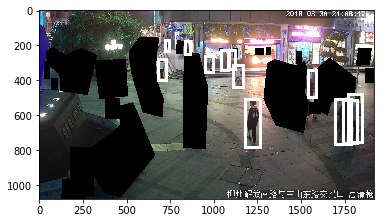

12
10
(0.0, 2.0, 0.0)
/home/wangjilong/data/hardexamples/ImageSet/3_00107966.jpg


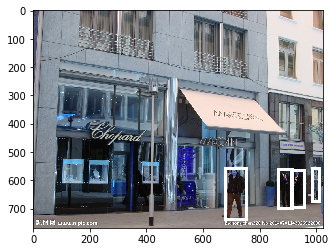

4
3
(0.0, 1.0, 0.0)
/home/wangjilong/data/hardexamples/ImageSet/liuzhoubayilubbg_115.jpg


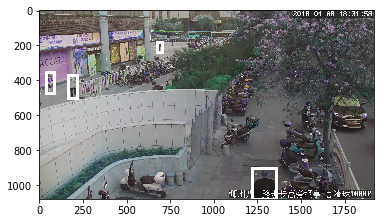

4
8
(0.0, 1.0, 5.0)
/home/wangjilong/data/hardexamples/ImageSet/6_32375.jpg


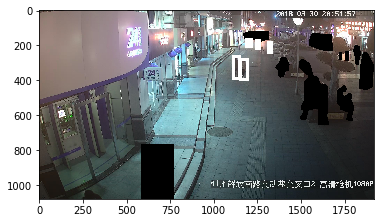

6
10
(0.0, 1.0, 5.0)
/home/wangjilong/data/hardexamples/ImageSet/4_3567.jpg


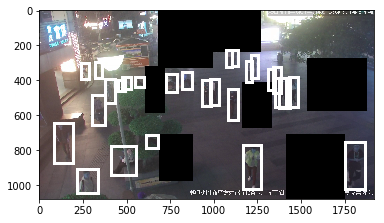

27
25
(0.0, 3.0, 1.0)
/home/wangjilong/data/hardexamples/ImageSet/4_3132.jpg


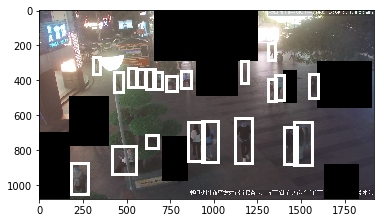

21
19
(0.0, 2.0, 0.0)
/home/wangjilong/data/hardexamples/ImageSet/ch09_20171231091524_72270.jpg


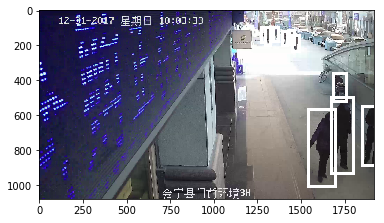

10
14
(0.0, 3.0, 7.0)
/home/wangjilong/data/hardexamples/ImageSet/9_41325.jpg


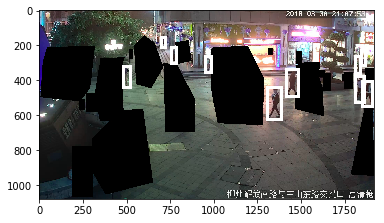

10
9
(0.0, 1.0, 0.0)
/home/wangjilong/data/hardexamples/ImageSet/4_13572.jpg


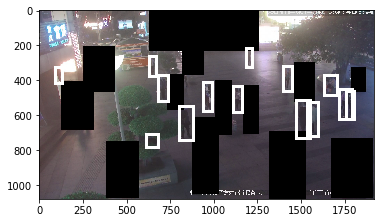

14
17
(0.0, 1.0, 4.0)
/home/wangjilong/data/hardexamples/ImageSet/5_66008.jpg


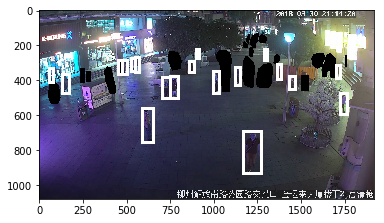

19
17
(0.0, 5.0, 3.0)
/home/wangjilong/data/hardexamples/ImageSet/4_19227.jpg


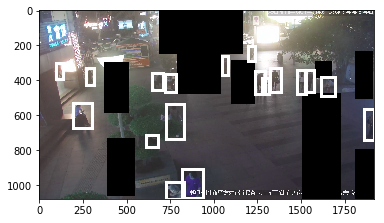

18
17
(0.0, 2.0, 1.0)
/home/wangjilong/data/hardexamples/ImageSet/cd_0939.jpg


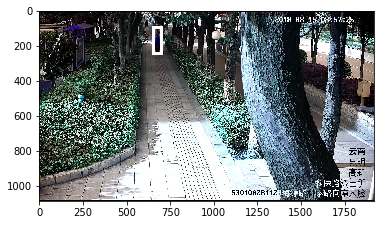

1
5
(0.0, 1.0, 5.0)
/home/wangjilong/data/hardexamples/ImageSet/ch02_20180618151922_16928.jpg


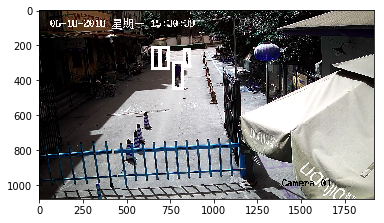

4
7
(0.0, 3.0, 6.0)
/home/wangjilong/data/hardexamples/ImageSet/ch02_20180617180654_5180.jpg


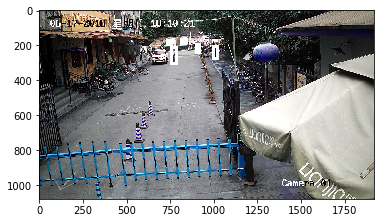

3
16
(0.0, 1.0, 14.0)
/home/wangjilong/data/hardexamples/ImageSet/ch02_20180617080645_38147.jpg


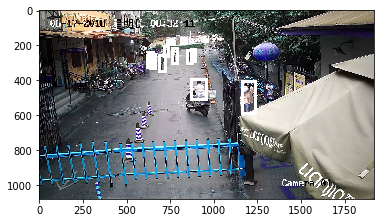

10
14
(1.0, 1.0, 6.0)
/home/wangjilong/data/hardexamples/ImageSet/gsun_81278b710cce1ed041346f088321db38.jpg


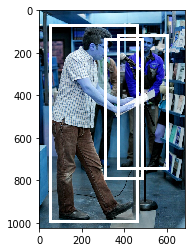

3
2
(0.0, 1.0, 0.0)
/home/wangjilong/data/hardexamples/ImageSet/cd_1745.jpg


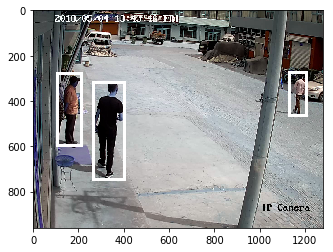

3
4
(0.0, 0.0, 1.0)


In [28]:

import argparse
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import cv2
import json
def ShowJson(img, results):
    plt.figure()
    plt.imshow(img)
    ax = plt.gca()
    for i in results:
        name = '1'
        xmin = i['bbox'][0]
        ymin = i['bbox'][1]
        xmax = i['bbox'][0] + i['bbox'][2]
        ymax = i['bbox'][3] + i['bbox'][1]
        coords = (xmin, ymin), xmax - xmin, ymax - ymin
        ax.add_patch(plt.Rectangle(*coords, fill=False, edgecolor='white', linewidth=3))
        plt.imshow(img)
    plt.show()

def compute_iou(rec1, rec2):
    one_x, one_y, one_w, one_h = rec1
    two_x, two_y, two_w, two_h = rec2
    if((abs(one_x - two_x) < ((one_w + two_w) / 2.0)) and (abs(one_y - two_y) < ((one_h + two_h) / 2.0))):
        lu_x_inter = max((one_x - (one_w / 2.0)), (two_x - (two_w / 2.0)))
        lu_y_inter = min((one_y + (one_h / 2.0)), (two_y + (two_h / 2.0)))

        rd_x_inter = min((one_x + (one_w / 2.0)), (two_x + (two_w / 2.0)))
        rd_y_inter = max((one_y - (one_h / 2.0)), (two_y - (two_h / 2.0)))

        inter_w = abs(rd_x_inter - lu_x_inter)
        inter_h = abs(lu_y_inter - rd_y_inter)

        inter_square = inter_w * inter_h
        union_square = (one_w * one_h) + (two_w * two_h) - inter_square

        calcIOU = inter_square / union_square * 1.0
        return calcIOU
    else:
        return 0
    
det_dir = 'detout'
img_dir = '/home/wangjilong/data/hardexamples/ImageSet/'
# img_dir = '/home/wangjilong/data/zhili_coco_posneg/ImageSet/'
ann_dir = '/home/wangjilong/data/hardexamples/Annotations/'
# name = list(open('hardexample.txt','r').readlines())
name = os.listdir(ann_dir)
# name = [x[:-1] for x in name]
img_name = [x[:-5]+'.jpg' for x in name]
for i in range(0,50):
    img = cv2.imread(os.path.join(img_dir, img_name[i]))
    print(os.path.join(img_dir, img_name[i]))
    bbox = json.load(open(os.path.join(det_dir, name[i][:-5]+'_dets.json'), 'r'))
    bbox = bbox['results']
    ShowJson(img, bbox)


    
    det_file = os.path.join(det_dir, name[i][:-5]+'_dets.json')
    ann_file = os.path.join(ann_dir, name[i])

    ann = json.load(open(ann_file, 'r'))
    result = json.load(open(det_file, 'r'))
    result = result['results']
    ann = ann['annotation']

    for res in result:
        res['count'] = 0
    for gt in ann:
        gt['count'] = 0

    print(len(result))
    print(len(ann))
    for i in range(len(result)):
        bbox2 = result[i]['bbox']
        rect2 = [bbox2[0], bbox2[1], bbox2[2], bbox2[3]]
#         print(i, result[i]['bbox'])
        max_iou = (-1, 0)
        for j in range(len(ann)):
            
            bbox = ann[j]['bbox']
            rect = [bbox[0], bbox[1], bbox[2], bbox[3]]
#             print(ann[j]['bbox'], compute_iou(rect, rect2))
            if compute_iou(rect, rect2) > max_iou[1] and compute_iou(rect, rect2) > 0.5:
                max_iou = (j, compute_iou(rect, rect2))
        if max_iou[0] != -1:
            ann[max_iou[0]]['count'] += 1
            result[i]['count'] += 1
#             print(ann[max_iou[0]], result[i])
#             print(max_iou[1])

    multi_bbox = 0.
    mismatch_bbox = 0.
    lost_bbox = 0.
    for gt in ann:
        if gt['count'] > 1:
            multi_bbox += 1
        if gt['count'] == 0:
            lost_bbox +=1
    for res in result:
        if res['count'] == 0:
            mismatch_bbox += 1
    print(multi_bbox, mismatch_bbox, lost_bbox)


In [21]:
caffe.set_device(3)
caffe.set_mode_gpu()

# load model
model_def = 'models/Pelee/coco/refinedet_pelee_512x512/deploy.prototxt'
model_weights = 'models/Pelee/coco/refinedet_pelee_512x512/coco_refinedet_pelee_512x512_iter_62.caffemodel'
net = caffe.Net(model_def, model_weights, caffe.TEST)

# image preprocessing
img_resize = 1024
net.blobs['data'].reshape(1, 3, img_resize, img_resize)
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2, 0, 1))
transformer.set_mean('data', np.array([104, 117, 123]))  # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2, 1, 0))  # the reference model has channels in BGR order instead of RGB

im_names = os.listdir('/home/wangjilong/pedestrian/dataset/test/3/')
im_names = [x for x in im_names if 'dets' not in x]
count = len(im_names)
import time;
time_count = 0
for im_name in im_names:
    image_file = '/home/wangjilong/pedestrian/dataset/test/3/' + im_name
    image = caffe.io.load_image(image_file)
    transformed_image = transformer.preprocess('data', image)
    net.blobs['data'].data[...] = transformed_image
    time_start = time.time()
    detections = net.forward()['detection_out']
    time_end = time.time()
    time_count = time_count + time_end-time_start
print(time_count)

8.67505431175


In [25]:
print(count)
print((time_count)/count)

235
0.0369151247309
